# imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
from pathlib import Path
import torch
from datasets import load_dataset
from transformers import ConvNextV2ForImageClassification, ConvNextV2Config
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm


/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# cifar10 test

In [7]:
RUNS_DIR = "/mnt/ssd-1/adam/basin-volume"

In [10]:
def evaluate_checkpoints(model_path):
    """
    Evaluate model checkpoints and plot training progress.
    
    Args:
        model_path (str): Path after /mnt/ssd-1/adam/basin-volume/runs/
                         e.g., "cifar10/convnext"
    """
    
    # Load and process datasets
    ds = load_dataset("cifar10")
    train_ds = ds["train"].select(range(5000))  # ~10% of 50k training samples
    val_ds = ds["test"].select(range(1000))     # 10% of 10k test samples
    
    transform = T.Compose([T.ToTensor()])
    
    def preprocess(examples):
        return {
            "pixel_values": [transform(image.convert("RGB")) for image in examples["img"]],
            "label": examples["label"]
        }
    
    train_ds = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
    val_ds = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)
    train_ds.set_format(type="torch")
    val_ds.set_format(type="torch")
    
    train_loader = DataLoader(train_ds, batch_size=128, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=128, num_workers=4)
    
    # Get checkpoints
    checkpoints = sorted(
        Path(RUNS_DIR, model_path).glob("checkpoint-*"),
        key=lambda x: int(x.name.split("-")[1])
    )
    
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    steps = []
    
    for ckpt in tqdm(checkpoints):
        config = ConvNextV2Config.from_pretrained(ckpt)
        model = ConvNextV2ForImageClassification.from_pretrained(
            ckpt,
            config=config,
            torch_dtype=torch.float16
        ).cuda()
        model.eval()
        
        # Evaluate on both sets
        for loader, accuracies, losses in [(train_loader, train_accuracies, train_losses),
                                         (val_loader, val_accuracies, val_losses)]:
            correct = 0
            total = 0
            running_loss = 0.0
            
            with torch.no_grad():
                for batch in loader:
                    pixel_values = batch["pixel_values"].cuda().to(torch.float16)
                    labels = batch["label"].cuda()
                    
                    outputs = model(pixel_values, labels=labels)
                    predictions = outputs.logits.argmax(-1)
                    
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)
                    running_loss += outputs.loss.item() * labels.size(0)
            
            accuracy = correct / total
            avg_loss = running_loss / total
            if loader == train_loader:  # Only add steps once
                step = int(ckpt.name.split("-")[1])
                steps.append(step)
                print(f"Step {step}: Train acc: {accuracy:.3f}, loss: {avg_loss:.3f}", end="")
            else:
                print(f", Val acc: {accuracy:.3f}, loss: {avg_loss:.3f}")
            accuracies.append(accuracy)
            losses.append(avg_loss)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Plot accuracies
    ax1.semilogx(steps, train_accuracies, "-o", label="Train")
    ax1.semilogx(steps, val_accuracies, "-o", label="Validation")
    ax1.grid(True)
    ax1.set_ylabel("Accuracy")
    ax1.set_title(f"Training Progress for {model_path}")
    ax1.legend()
    
    # Plot losses
    ax2.semilogx(steps, train_losses, "-o", label="Train")
    ax2.semilogx(steps, val_losses, "-o", label="Validation")
    ax2.grid(True)
    ax2.set_xlabel("Training Steps")
    ax2.set_ylabel("Cross Entropy Loss")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

    return train_accuracies, val_accuracies, train_losses, val_losses

  0%|          | 0/9 [00:00<?, ?it/s]

Step 1: Train acc: 0.104, loss: 2.304

 11%|█         | 1/9 [00:02<00:17,  2.16s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Train acc: 0.104, loss: 2.304

 22%|██▏       | 2/9 [00:04<00:14,  2.03s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Train acc: 0.104, loss: 2.302

 33%|███▎      | 3/9 [00:06<00:11,  1.98s/it]

, Val acc: 0.099, loss: 2.314
Step 8: Train acc: 0.107, loss: 2.296

 44%|████▍     | 4/9 [00:07<00:09,  1.94s/it]

, Val acc: 0.099, loss: 2.305
Step 16: Train acc: 0.138, loss: 2.286

 56%|█████▌    | 5/9 [00:09<00:07,  1.92s/it]

, Val acc: 0.150, loss: 2.287
Step 32: Train acc: 0.148, loss: 2.259

 67%|██████▋   | 6/9 [00:11<00:05,  1.95s/it]

, Val acc: 0.134, loss: 2.269
Step 64: Train acc: 0.168, loss: 2.158

 78%|███████▊  | 7/9 [00:13<00:03,  1.93s/it]

, Val acc: 0.187, loss: 2.164
Step 128: Train acc: 0.207, loss: 2.108

 89%|████████▉ | 8/9 [00:15<00:01,  1.93s/it]

, Val acc: 0.196, loss: 2.130
Step 256: Train acc: 0.319, loss: 1.894

100%|██████████| 9/9 [00:17<00:00,  1.94s/it]

, Val acc: 0.318, loss: 1.874


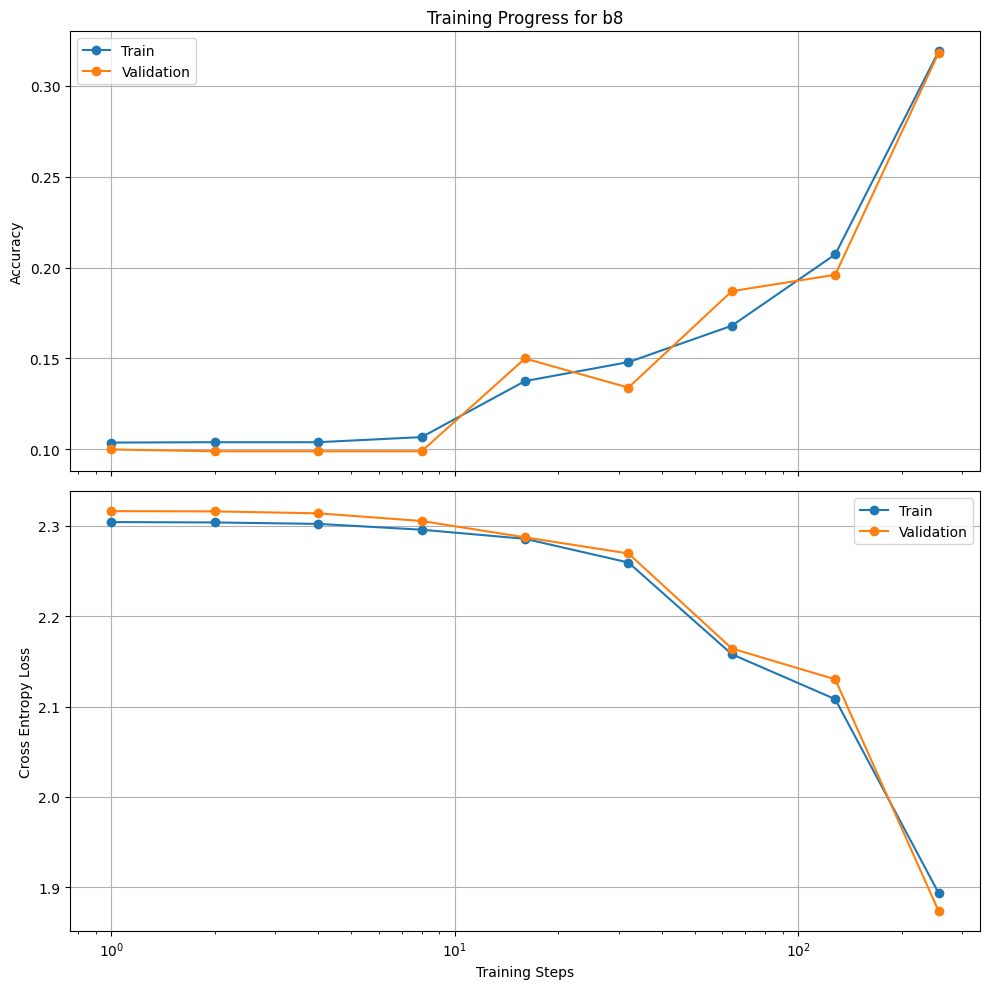

In [8]:
metrics = evaluate_checkpoints("b8")

  0%|          | 0/7 [00:00<?, ?it/s]

Step 1: Train acc: 0.104, loss: 2.304

 14%|█▍        | 1/7 [00:03<00:19,  3.22s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Train acc: 0.104, loss: 2.304

 29%|██▊       | 2/7 [00:05<00:13,  2.65s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Train acc: 0.104, loss: 2.302

 43%|████▎     | 3/7 [00:07<00:09,  2.31s/it]

, Val acc: 0.099, loss: 2.314
Step 8: Train acc: 0.107, loss: 2.296

 57%|█████▋    | 4/7 [00:09<00:06,  2.17s/it]

, Val acc: 0.099, loss: 2.305
Step 16: Train acc: 0.138, loss: 2.286

 71%|███████▏  | 5/7 [00:11<00:04,  2.11s/it]

, Val acc: 0.150, loss: 2.287
Step 32: Train acc: 0.148, loss: 2.259

 86%|████████▌ | 6/7 [00:13<00:02,  2.07s/it]

, Val acc: 0.134, loss: 2.269
Step 64: Train acc: 0.168, loss: 2.158

100%|██████████| 7/7 [00:15<00:00,  2.21s/it]

, Val acc: 0.187, loss: 2.164


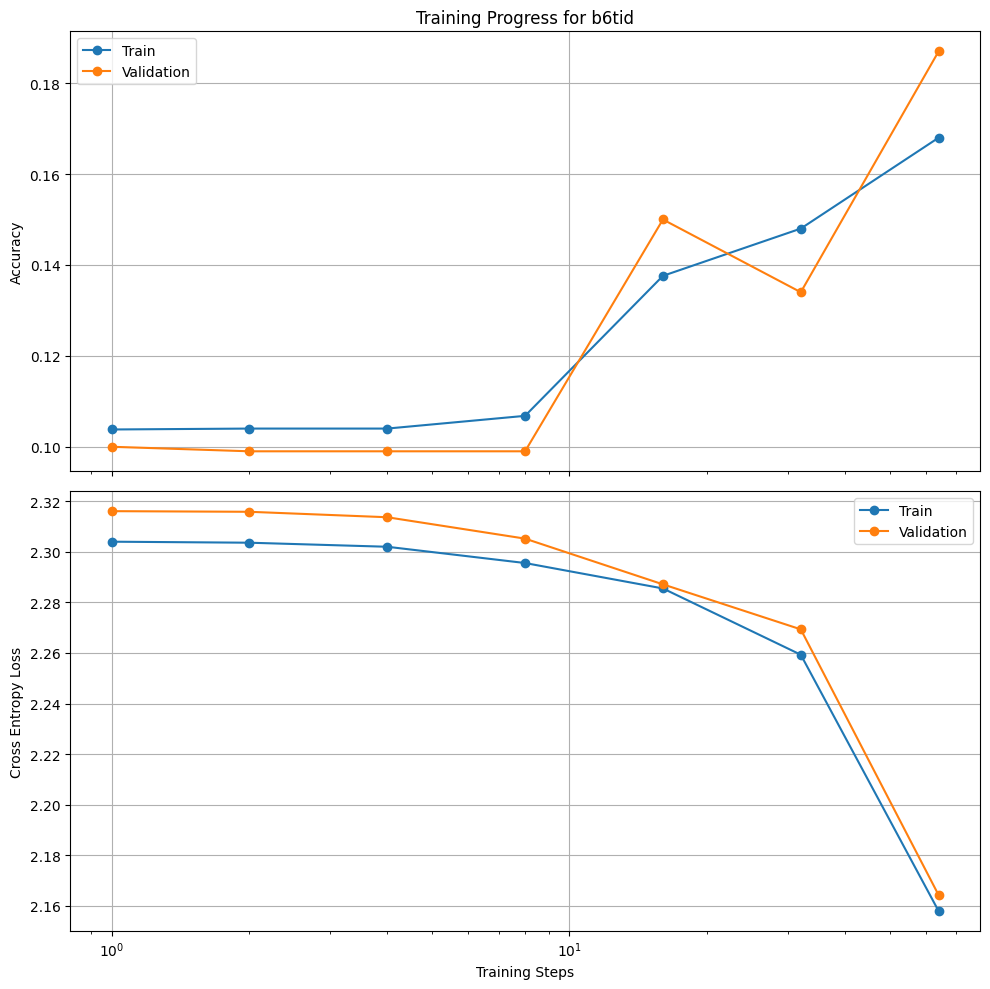

In [11]:
metrics6 = evaluate_checkpoints("b6tid")

  0%|          | 0/7 [00:00<?, ?it/s]

Step 1: Train acc: 0.104, loss: 2.304

 14%|█▍        | 1/7 [00:02<00:12,  2.13s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Train acc: 0.104, loss: 2.304

 29%|██▊       | 2/7 [00:04<00:10,  2.02s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Train acc: 0.104, loss: 2.302

 43%|████▎     | 3/7 [00:06<00:07,  1.99s/it]

, Val acc: 0.099, loss: 2.314
Step 8: Train acc: 0.107, loss: 2.296

 57%|█████▋    | 4/7 [00:08<00:05,  1.99s/it]

, Val acc: 0.099, loss: 2.305
Step 16: Train acc: 0.138, loss: 2.286

 71%|███████▏  | 5/7 [00:10<00:04,  2.01s/it]

, Val acc: 0.150, loss: 2.287
Step 32: Train acc: 0.148, loss: 2.259

 86%|████████▌ | 6/7 [00:11<00:01,  1.97s/it]

, Val acc: 0.134, loss: 2.269
Step 64: Train acc: 0.168, loss: 2.158

100%|██████████| 7/7 [00:13<00:00,  1.98s/it]

, Val acc: 0.187, loss: 2.164


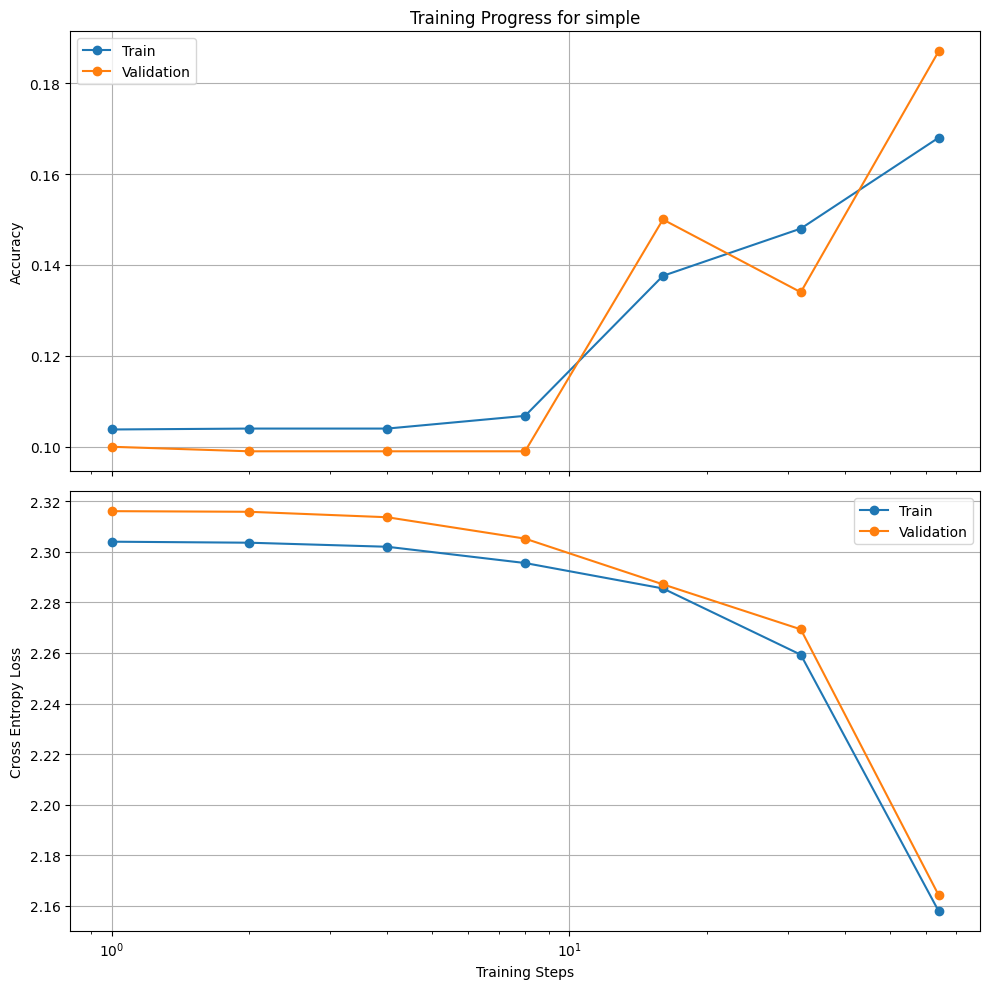

In [13]:
metrics6 = evaluate_checkpoints("runs/simple")